# Boosting

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import dump, load

In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn import tree

In [3]:
from preprocessing import reemplazarNulls,reemplazarCategoricas,reemplazarFechas,regularizar,targetBooleano

[###] All Done                                              


In [4]:
from utilities import score, df_feat, df_targ, train_val

### Codigo a correr

In [5]:
MAX_JOBS = 5

**Run :** Entrenar Nuevamente o Cargar Entrenado

In [6]:
runSimple = False
runValidated = False
runValidated2 = False
runReg = False

**Save :** Guardar Modelo (pisa anterior)

In [7]:
saveSimple = True
saveValidated = True
saveValidated2 = True
saveReg = True

### Preprocesamiento

In [8]:
targetBooleano(df_targ, inplace=True)
reemplazarNulls(df_feat , inplace=True)
reemplazarCategoricas(df_feat , inplace=True)
reemplazarFechas(df_feat , inplace=True)
df_feat_r = regularizar(df_feat)

In [9]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102356 entries, 0 to 102355
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            102356 non-null  int64  
 1   direccion_viento_tarde        102356 non-null  float64
 2   direccion_viento_temprano     102356 non-null  float64
 3   horas_de_sol                  102356 non-null  float64
 4   humedad_tarde                 102356 non-null  float64
 5   humedad_temprano              102356 non-null  float64
 6   llovieron_hamburguesas_hoy    102356 non-null  bool   
 7   mm_evaporados_agua            102356 non-null  float64
 8   mm_lluvia_dia                 102356 non-null  float64
 9   nubosidad_tarde               102356 non-null  float64
 10  nubosidad_temprano            102356 non-null  float64
 11  presion_atmosferica_tarde     102356 non-null  float64
 12  presion_atmosferica_temprano  102356 non-nul

In [10]:
train_feat, val_feat, train_targ, val_targ = train_val( df_feat, df_targ )

In [11]:
train_targ = train_targ.llovieron_hamburguesas_al_dia_siguiente
val_targ = val_targ.llovieron_hamburguesas_al_dia_siguiente

In [12]:
train_feat_r, val_feat_r, train_targ_r, val_targ_r = train_val( df_feat_r, df_targ )
train_targ_r = train_targ_r.llovieron_hamburguesas_al_dia_siguiente
val_targ_r = val_targ_r.llovieron_hamburguesas_al_dia_siguiente

## Entrenamiento

### Simple

In [13]:
if (runSimple):
    boost_simple = GradientBoostingClassifier(
        random_state=1,
        max_depth=3,
        min_samples_split=200,
    )
    boost_simple.fit( train_feat, train_targ )
    
    # Guardar
    if(saveSimple):
        dump(boost_simple, 'models/Ensambles/boost_simple.sk') 
else:
    # Cargar
    boost_simple = load('models/Ensambles/boost_simple.sk')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
AUC-ROC: 0.792912334802958
ACCURACY: 0.841051191871825
PRESICION: 0.46593886462882095
RECALL: 0.7253569000679809
CONFUSION MATRIX


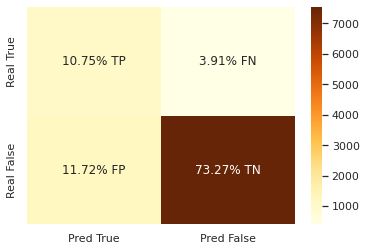

In [14]:
%time
pred_s = boost_simple.predict(val_feat)
prob_s = boost_simple.predict_proba(val_feat)
score(pred_s, val_targ, prob_s)

### Validado

In [15]:
if( runValidated ):
    boost = GradientBoostingClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(1, 20, 1),
        'min_samples_leaf': np.arange(50, 1000, 50),
        'n_estimators': np.arange(50,500,50),
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.05,0.1,0.2],
    }
    
    boost_grid = RandomizedSearchCV(
        boost,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveValidated):
        dump(boost_grid, 'models/Ensambles/boost_grid.sk')
else:
    # Cargar
    boost_grid = load('models/Ensambles/boost_grid.sk')

In [16]:
print(f"Best score: {boost_grid.best_score_}")
print(f"Best params {boost_grid.best_params_}")

Best score: 0.8900215501117197
Best params {'n_estimators': 300, 'min_samples_leaf': 450, 'max_depth': 17, 'loss': 'deviance', 'learning_rate': 0.05}


In [17]:
boost = boost_grid.best_estimator_

AUC-ROC: 0.7353058911847107
ACCURACY: 0.8491598280578351
PRESICION: 0.7222884386174017
RECALL: 0.5292576419213973
CONFUSION MATRIX
CPU times: user 486 ms, sys: 37.9 ms, total: 524 ms
Wall time: 493 ms


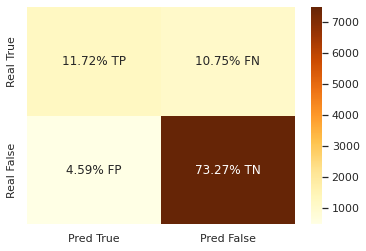

In [18]:
%%time
pred = boost.predict(val_feat)
prob = boost.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

In [19]:
if(saveValidated):
    dump(boost, 'models/Ensambles/boost.sk')

### Optimizando mas hiperparametros

In [20]:
if( runValidated2 ):
    boost2 = GradientBoostingClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(15, 19, 1),
        'min_samples_leaf': np.arange(50, 200, 50),
        'min_samples_split': np.arange(50, 200, 50),
        'n_estimators': np.arange(200,500,100),
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.03,0.05,0.07],
        'criterion' :['friedman_mse','squared_error']
    }
    
    boost_grid2 = HalvingGridSearchCV(
        boost2,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveValidated2):
        dump(boost_grid2, 'models/Ensambles/boost2_grid.sk')
else:
    # Cargar
    boost_grid2 = load('models/Ensambles/boost2_grid.sk')

In [21]:
print(f"Best score: {boost_grid2.best_score_}")
print(f"Best params {boost_grid2.best_params_}")

Best score: 0.8880131564342968
Best params {'criterion': 'squared_error', 'learning_rate': 0.03, 'loss': 'exponential', 'max_depth': 18, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 200}


In [22]:
boost2 = boost_grid2.best_estimator_

AUC-ROC: 0.7309102819578003
ACCURACY: 0.8515044939429465
PRESICION: 0.743979721166033
RECALL: 0.5126637554585153
CONFUSION MATRIX
CPU times: user 576 ms, sys: 21.6 ms, total: 598 ms
Wall time: 560 ms


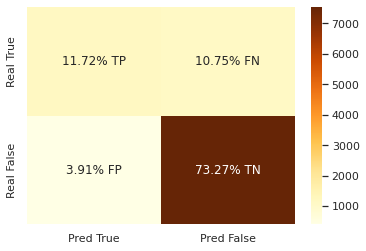

In [23]:
%%time
pred2 = boost2.predict(val_feat)
prob2 = boost2.predict_proba(val_feat)
score(val_targ, pred2, prob2[:,1])

In [24]:
if(saveValidated2):
    dump(boost2, 'models/Ensambles/boost2.sk')

### Reg

In [25]:
if( runReg ):
    boost3 = GradientBoostingClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(1, 20, 1),
        'min_samples_leaf': np.arange(50, 1000, 50),
        'n_estimators': np.arange(50,500,50),
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.05,0.1,0.2],
    }
    
    boost_grid3 = RandomizedSearchCV(
        boost3,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat_r, train_targ_r)
    
    # Guardar
    if(saveReg):
        dump(boost_grid3, 'models/Ensambles/boost_grid_r.sk')
else:
    # Cargar
    boost_grid3 = load('models/Ensambles/boost_grid_r.sk')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [26]:
print(f"Best score: {boost_grid3.best_score_}")
print(f"Best params {boost_grid3.best_params_}")

Best score: 0.8779575973793345
Best params {'n_estimators': 250, 'min_samples_leaf': 550, 'max_depth': 16, 'loss': 'deviance', 'learning_rate': 0.05}


In [27]:
boost3 = boost_grid3.best_estimator_

AUC-ROC: 0.7268467175267114
ACCURACY: 0.8485736615865572
PRESICION: 0.7341772151898734
RECALL: 0.5065502183406113
CONFUSION MATRIX
CPU times: user 611 ms, sys: 120 ms, total: 731 ms
Wall time: 442 ms


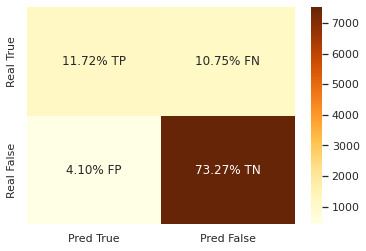

In [28]:
%%time
pred3 = boost3.predict(val_feat_r)
prob3 = boost3.predict_proba(val_feat_r)
score(val_targ_r, pred3, prob3[:,1])

In [29]:
if(saveReg):
    dump(boost3, 'models/Ensambles/boost_r.sk')